In [3]:
import ast
import pickle
import json
import numpy as np
import pandas as pd

from collections import defaultdict
from glob import glob

from orion.data import load_signal

In [4]:
dataset = pd.read_csv(
    'sintel/data/datasets.csv', index_col=0, header=None).applymap(
    ast.literal_eval).to_dict()[1]

pipelines = glob('results/save_pipelines/*')
cache = glob('results/cache/*')

pipeline_names = ['arima', 'tadgan', 'lstm_dynamic_threshold', 
                  'lstm_autoencoder', 'dense_autoencoder']

In [5]:
ANOMALIES = pd.read_csv('sintel/data/anomalies.csv')

def load_anomalies(signal):
    anomalies = ANOMALIES.set_index('signal').loc[signal].values[0]
    anomalies = pd.DataFrame(json.loads(anomalies), columns=['start', 'end'])
    return anomalies



In [6]:
remaining = []

for data, signals in dataset.items():
    for signal in signals:
        for pipeline in pipeline_names:
            exist = [x for x in pipelines 
                     if pipeline + '_' + signal + '_' + data in x]
            if len(exist) > 1:
                print((pipeline, signal, data))

In [7]:
dfs = []

for file in cache:
    dfs.append(pd.read_csv(file))

In [8]:
result = pd.read_csv('results/results.csv')

In [9]:
ORDER = ['lstm_dynamic_threshold', 'tadgan', 'lstm_autoencoder', 'arima', 'dense_autoencoder', 'azure']

DATASET_FAMILY = {
    "MSL": "NASA",
    "SMAP": "NASA",
    "YAHOOA1": "YAHOO",
    "YAHOOA2": "YAHOO",
    "YAHOOA3": "YAHOO",
    "YAHOOA4": "YAHOO",
    "artificialWithAnomaly": "NAB",
    "realAWSCloudwatch": "NAB",
    "realAdExchange": "NAB",
    "realTraffic": "NAB",
    "realTweets": "NAB"
}

DATASET_ABBREVIATION = {
    "MSL": "MSL",
    "SMAP": "SMAP",
    "YAHOOA1": "A1",
    "YAHOOA2": "A2",
    "YAHOOA3": "A3",
    "YAHOOA4": "A4",
    "artificialWithAnomaly": "Art",
    "realAWSCloudwatch": "AWS",
    "realAdExchange": "AdEx",
    "realTraffic": "Traf",
    "realTweets": "Tweets"   
}

def dataset_family(x):
    return DATASET_FAMILY[x]

def get_scores(results):
    results['group'] = results['dataset'].apply(dataset_family)
    df = results.groupby(['group', 'dataset', 'pipeline'])[['fp', 'fn', 'tp']].sum().reset_index()

    precision = df['tp'] / (df['tp'] + df['fp'])
    recall = df['tp'] / (df['tp'] + df['fn'])
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    df['f1'] = f1_score
    df['precision'] = precision
    df['recall'] = recall
    
    df = df.reset_index()
    df = df.groupby(['group', 'pipeline']).mean().reset_index()
    df = df.set_index(['group', 'pipeline'])[['f1', 'precision', 'recall']].unstack().T.reset_index(level=0)
    df = df.pivot(columns='level_0')
    df.columns = df.columns.rename('dataset', level=0)
    df.columns = df.columns.rename('metric', level=1)
    
    return df.loc[ORDER]

In [10]:
f1_results = get_scores(result)
f1_results

dataset                      NAB                          NASA            \
metric                        f1 precision    recall        f1 precision   
pipeline                                                                   
lstm_dynamic_threshold  0.555079  0.452236  0.734199  0.558827  0.471642   
tadgan                  0.605925  0.536370  0.721039  0.555729  0.473196   
lstm_autoencoder        0.640442  0.631905  0.654286  0.583333  0.567568   
arima                   0.513892  0.476010  0.565714  0.380512  0.382678   
dense_autoencoder       0.598855  0.666000  0.546667  0.636089  0.707393   
azure                   0.148855  0.085752  0.892121  0.041029  0.021176   

dataset                              YAHOO                      
metric                    recall        f1 precision    recall  
pipeline                                                        
lstm_dynamic_threshold  0.700041  0.771869  0.880447  0.715546  
tadgan                  0.673300  0.568142  0.697513  0.507100  
lstm_autoencoder        0.600746  0.524240  0.760079  0.468699  
arima                   0.379975  0.756525  0.852392  0.713945  
dense_autoencoder       0.578358  0.430708  0.793162  0.382667  
azure                   0.872927  0.493647  0.352143  0.912401

In [11]:
debug_files = glob('results/debug/*')

assert len(debug_files) == 2460

debug = defaultdict(list)

debug_files[0]
for file in debug_files:
    with open(file, 'rb') as f:
        dictionary = pickle.load(f)
        
    for pipe in ORDER:
        if pipe in file:
            name = "_".join(file.split('/')[-1].replace(pipe + '_', '').split('_')[:-3])
            debug[pipe].append((name, dictionary))

In [12]:
# primitive profiling 

data_path = './sintel/data/{}.csv'
sub = result[['pipeline', 'signal', 'status']]

primitive_profile = defaultdict(list)
for pipe in ORDER:
    if pipe == 'azure':
        continue
        
    for s, p in debug[pipe]:
        status = sub[sub['pipeline'] == pipe]
        status = status[status['signal'] == s]['status'].values[0]
        if status == 'ERROR':
            continue
        
        fit_time = 0
        predict_time = 0
        for phase, output in p.items():
            if output is not None:
                if phase == "fit":
                    for item in ['fit', 'produce']:
                        fit_time += sum([x['time'] for x in output[item].values()])

                else:
                    predict_time = sum([x['time'] for x in output[item].values()])
                    

        primitive_profile[pipe].append(fit_time + predict_time)

In [13]:
dfs = []
sub = result[['pipeline', 'elapsed', 'status']]

for pipe in ORDER:
    if pipe in primitive_profile.keys():
        elapsed = sub[sub['pipeline'] == pipe]
        elapsed = elapsed[elapsed['status'] == 'OK']['elapsed']
        df = pd.DataFrame({"pipeline": [pipe]*len(primitive_profile[pipe]), 
                           "stand-alone": primitive_profile[pipe],
                           "end-to-end": elapsed})
        dfs.append(df)
        
time = pd.concat(dfs)
time = time.set_index('pipeline').stack().reset_index()
time.columns = ['pipeline', 'source', 'time']

time.head()

,pipeline,source,time
0,lstm_dynamic_threshold,stand-alone,468.584990
1,lstm_dynamic_threshold,end-to-end,580.903420
2,lstm_dynamic_threshold,stand-alone,677.090693
3,lstm_dynamic_threshold,end-to-end,1014.167077
4,lstm_dynamic_threshold,stand-alone,569.314418


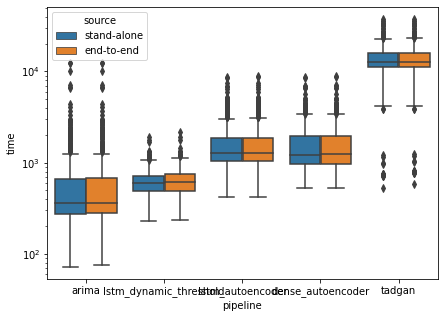

In [14]:
import matplotlib.pyplot as plt

import seaborn as sns

order = ['arima', 'lstm_dynamic_threshold', 'lstm_autoencoder', 'dense_autoencoder', 'tadgan']

f, ax = plt.subplots(figsize=(7, 5))
ax.set(yscale="log")

sns.boxplot(x="pipeline", y="time", hue='source', data=time,
            order=order, ax=ax);

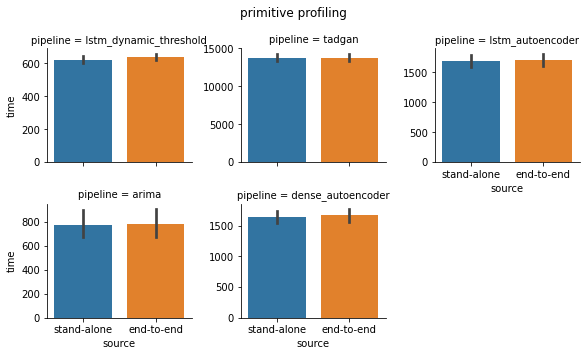

In [15]:
sns.catplot(x="source", y='time', col="pipeline", col_wrap=3, sharey=False,
            data=time, kind="bar", height=2.5, aspect=1.1)

plt.suptitle("primitive profiling")
plt.tight_layout()
# plt.savefig('images/primitive_profiles_abs.pdf');

In [14]:
dfs = []
sub = result[['pipeline', 'elapsed', 'status']]

for pipe in ORDER:
    if pipe in primitive_profile.keys():
        elapsed = sub[sub['pipeline'] == pipe]
        elapsed = elapsed[elapsed['status'] == 'OK']['elapsed']
        df = pd.DataFrame({"pipeline": [pipe]*len(primitive_profile[pipe]), 
                           "stand-alone": sorted(primitive_profile[pipe]),
                           "end-to-end": sorted(elapsed)})
        dfs.append(df)
        
time = pd.concat(dfs)
time['delta'] = (time['end-to-end'] - time['stand-alone'])

In [19]:
mean

pipeline
arima                      4.505606
lstm_autoencoder          12.823856
lstm_dynamic_threshold    15.634113
dense_autoencoder         17.764156
tadgan                    28.695505
Name: delta, dtype: float64

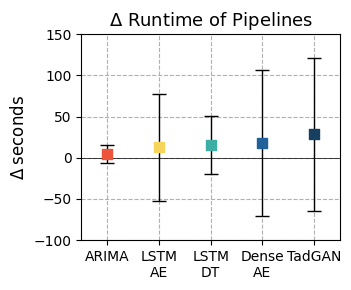

In [63]:
# delta plot

import matplotlib.pyplot as plt
plt.style.use('default')

colors = ["#ED553B", "#F6D55C", "#3CAEA3", "#20639B", "#173F5F"]

order = ['arima', 'lstm_autoencoder', 'lstm_dynamic_threshold', 'dense_autoencoder', 'tadgan']
labels = ['ARIMA', 'LSTM\nAE', 'LSTM\nDT', 'Dense\nAE', 'TadGAN']

mean = time.groupby('pipeline')['delta'].mean().loc[order]
std = time.groupby('pipeline')['delta'].std().loc[order]

fig = plt.figure(figsize=(3.6, 3))

plt.errorbar(range(len(mean.index)), mean, yerr=2*std, linestyle='', marker=None,
             capsize=5, ecolor='k', lw=1, zorder=2)
plt.scatter(range(len(mean.index)), mean, c=colors, marker='s', s=50, zorder=3)

plt.axhline(0, c='k', ls='-', lw=0.5)

ticksx, labelsx = plt.xticks()

ax = plt.gca()
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

plt.grid(True, linestyle='--')
plt.xlim([-0.5, len(labels)-0.5])
plt.ylim([-100, 150])
plt.title(r'$\Delta$ Runtime of Pipelines', size=13)
# plt.xlabel('pipelines', size=12)
plt.ylabel(r'$\Delta\;$seconds', size=12)
plt.tight_layout()
plt.savefig('images/primitive_profiles_delta.pdf');
plt.show()

In [51]:
sub = result[['pipeline', 'signal', 'status']]

fit_time = defaultdict(list)
predict_time = defaultdict(list)
memory = defaultdict(list)

for pipe in ORDER:
    if pipe == 'azure':
        continue
        
    for s, p in debug[pipe]:
        ftime = 0
        ptime = 0
        
        # memory
        fmemory = 0
        pmemory = 0
        for phase, output in p.items():
            if output is not None:
                if phase == "fit":
                    for item in ['fit', 'produce']:
                        ftime += sum([x['time'] for x in output[item].values()])
                        fmemory += sum([x['memory'] for x in output[item].values()])

                else:
                    ptime = sum([x['time'] if k != 'orion.primitives.timeseries_errors.reconstruction_errors#1'\
                                 else 10for k, x in output['produce'].items()])
                    pmemory = sum([x['memory'] for x in output['produce'].values()])
                    

        fit_time[pipe].append(ftime)
        predict_time[pipe].append(ptime)
        memory[pipe].append(pmemory + fmemory)

In [52]:
dfs = []

for pipe in ORDER:
    if pipe in memory.keys():
        df = pd.DataFrame({"pipeline": [pipe]*len(memory[pipe]), 
                           "fit_time": fit_time[pipe],
                           "predict_time": predict_time[pipe],
                           "memory": [x / 10**3 for x in memory[pipe]]})
        dfs.append(df)
        
profiles = pd.concat(dfs)
profiles = profiles.set_index('pipeline').stack().reset_index()
profiles.columns = ['pipeline', 'source', 'value']

profiles.head()

,pipeline,source,value
0,lstm_dynamic_threshold,fit_time,454.928459
1,lstm_dynamic_threshold,predict_time,13.656531
2,lstm_dynamic_threshold,memory,805486.592000
3,lstm_dynamic_threshold,fit_time,672.452759
4,lstm_dynamic_threshold,predict_time,4.637934


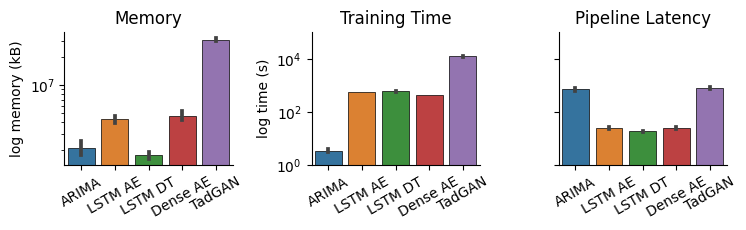

In [14]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
plt.style.use('default')

mpl.rcParams['hatch.linewidth'] = 0.2  # previous pdf hatch linewidth

order = ['arima', 'lstm_autoencoder', 'lstm_dynamic_threshold', 'dense_autoencoder', 'tadgan']
labels = ['ARIMA', 'LSTM AE', 'LSTM DT', 'Dense AE', 'TadGAN']

profiles['pipeline'] = pd.Categorical(profiles['pipeline'], order)
profiles = profiles.sort_values('pipeline')

# fig = plt.figure(figsize=(50, 10))

g = sns.catplot(x="pipeline", y='value', col="source", col_wrap=3, sharey=False,
                data=profiles, kind="bar", height=2.4, aspect=1.05, margin_titles=False, 
                saturation=0.7, linewidth=0.5, edgecolor='k',
                col_order=['memory', 'fit_time', 'predict_time'])

for i in range(3):
    g.fig.get_axes()[i].set_yscale('log')

axes = g.axes.flatten()
axes[1].set_ylabel('log time (s)')
axes[0].set_ylabel('log memory (kB)')
axes[1].set_ylim([1, 10**5])
axes[2].set_ylim([1, 10**5])
# axes[2].set_ylim([1, 10**9])

axes[2].set(yticklabels=[])

axes[1].set_title("Training Time")
axes[2].set_title("Pipeline Latency")
axes[0].set_title("Memory")

for i in range(3):
    axes[i].set_xticks(range(len(labels)))
    axes[i].set_xticklabels(labels, rotation=30)
    axes[i].set_xlabel('')

cmap = plt.get_cmap("tab10")
colors = [mpatches.Patch(color=cmap(i), label=labels[i]) for i in range(len(labels))]
# plt.legend(bbox_to_anchor=(1.05, 1.1), loc='upper left', handles=colors, edgecolor='white', fancybox=True);

plt.tight_layout()
# plt.savefig('images/pipeline_profile3.pdf');

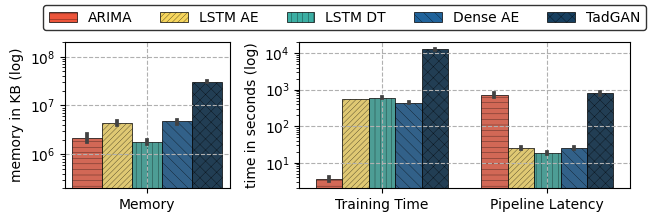

In [55]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
plt.style.use('default')
mpl.rcParams['hatch.linewidth'] = 0.2  # previous pdf hatch linewidth

palette = sns.color_palette(colors)

order = ['arima', 'lstm_autoencoder', 'lstm_dynamic_threshold', 'dense_autoencoder', 'tadgan']
labels = ['ARIMA', 'LSTM AE', 'LSTM DT', 'Dense AE', 'TadGAN']
xlabels = [['Memory'], ['Training Time', 'Pipeline Latency']]

profiles['pipeline'] = pd.Categorical(profiles['pipeline'], order)
profiles = profiles.sort_values('pipeline')

fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(6.5, 2),
    gridspec_kw={'width_ratios':[1,2]}
)

# Define some hatches
hatches = ['-', '//', '|', '\\', 'x'] * 2
   
temp = profiles[profiles['source'] == 'memory']
g = sns.barplot(x="source", y='value', hue="pipeline", ax=axes[0], palette=palette,
                data=temp, saturation=0.7, linewidth=0.5, edgecolor='k')

# Loop over the bars
for i,thisbar in enumerate(g.patches):
    thisbar.set_hatch(hatches[i] * 3)
    
temp = pd.concat([profiles[profiles['source'] == 'fit_time'], profiles[profiles['source'] == 'predict_time']])
g = sns.barplot(x="source", y='value', hue="pipeline", ax=axes[1], palette=palette,
                data=temp, saturation=0.7, linewidth=0.5, edgecolor='k')

for bars, hatch in zip(g.containers, hatches):
    for bar in bars:
        bar.set_hatch(hatch * 3)
    
for i in range(2):
    axes[i].set_yscale('log')
    axes[i].grid(True, linestyle='--')
    axes[i].set_xticklabels(xlabels[i])
    axes[i].get_legend().remove()
    axes[i].set_xlabel('')
      
axes[0].set_ylim([0.2e6, 0.2e9])
axes[1].set_ylim([0.2e1, 0.2e5])
axes[0].set_ylabel('memory in KB (log)')
axes[1].set_ylabel('time in seconds (log)')

handles = [mpatches.Patch(facecolor=colors[i], label=labels[i], hatch=hatches[i] * 3, ec='k', lw=0.5) 
           for i in range(len(labels))]
fig.legend(handles=handles, edgecolor='k', loc='upper center', bbox_to_anchor=(0.53, 1.12), ncol=len(labels))

plt.tight_layout()
plt.savefig('images/pipeline_profile4.pdf', bbox_inches='tight');

In [64]:
def get_anomalies_in_test(anomalies, start):
    df = anomalies.copy()
    remove = []
    for i, anom in df.iterrows():
        if anom.start < start and anom.end > start:
            df.at[i, 'start'] = start
        elif anom.start < start:
            remove.append(i)

    return df.drop(remove)

def safe_division(n, d):
    return n / d if d else 0


In [65]:
from orion.evaluation import contextual_confusion_matrix

DATA_PATH = 'sintel/data/{}'

all_scores = {}
all_pipelines = ["arima", "lstm_autoencoder", "lstm_dynamic_threshold", "dense_autoencoder", "tadgan"]

for pipeline_name in all_pipelines:
    feedback_files = glob('results/supervised2/{}/*'.format(pipeline_name))

    dataset = defaultdict(dict)

    for file in feedback_files:
        with open(file, 'rb') as f:
            iteration = pickle.load(f)

        d = file.split('/')[-1].split('_')[0]
        s = "_".join(file.split('/')[-1].split('_')[1:-1])
        try:
            dataset[d][s].append(iteration)
        except:
            dataset[d][s] = [iteration]


    test = []
    train = []

    tot_anom = 0

    ## READ ITERATIONS ##
    for data, signals in dataset.items():
        for signal, result in signals.items():
            data_path = DATA_PATH.format(signal + '.csv')
            truth = load_anomalies(signal)
            train_ts, test_ts = load_signal(data_path, test_size=0.3)
            start = test_ts['timestamp'].min()
            test_truth = get_anomalies_in_test(truth, start)
            tot_anom += len(test_truth)
            for iteration in result:
                test_anom = iteration['test_anomalies']
                train_anom = iteration['train_anomalies']

                if isinstance(test_anom, tuple):
                    for e in test_anom:
                        test.append(contextual_confusion_matrix(test_truth, e, weighted=False))

                    for e in train_anom:
                        train.append(contextual_confusion_matrix(truth, e, weighted=False))

                else:
                    test.append(contextual_confusion_matrix(test_truth, test_anom, weighted=False))
                    train.append(contextual_confusion_matrix(truth, train_anom, weighted=False))

    ## COMPUTE F1 SCORE ##
    score = []

    k = 2
    fp_sum, fn_sum, tp_sum = 0, 0, 0

    i = 0
    while i < (len(test)):
        tn1, fp1, fn1, tp1 = test[i]
        try:
            tn2, fp2, fn2, tp2 = test[i+1]
        except:
            tn2, fp2, fn2, tp2 = 0, 0, 0, 0
            
        fp_sum += fp1 + fp2
        fn_sum += fn1 + fn2
        tp_sum += tp1 + tp2

        fn_sum += (tot_anom - (fp_sum + fn_sum + tp_sum))
        rec = safe_division(tp_sum, (tp_sum + fn_sum))
        pre = safe_division(tp_sum, (tp_sum + fp_sum))

        f1 = safe_division(2 * rec * pre, (rec + pre))
        print("{} - precision = {}, recall = {}, f1 = {}".format(i, rec, pre, f1))
        score.append(f1)
        i += 2
        
    all_scores[pipeline_name] = score

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

0 - precision = 0.038461538461538464, recall = 1.0, f1 = 0.07407407407407407
2 - precision = 0.11538461538461539, recall = 1.0, f1 = 0.20689655172413793
4 - precision = 0.19230769230769232, recall = 1.0, f1 = 0.32258064516129037
6 - precision = 0.23076923076923078, recall = 1.0, f1 = 0.375
8 - precision = -0.035897435897435895, recall = 0.03070175438596491, f1 = 0.42424242424242425
10 - precision = -0.03463203463203463, recall = 0.03018867924528302, f1 = 0.4705882352941177
12 - precision = -0.04329004329004329, recall = 0.03745318352059925, f1 = 0.5555555555555559
14 - precision = -0.047619047619047616, recall = 0.041044776119402986, f1 = 0.5945945945945948
16 - precision = -0.047619047619047616, recall = 0.041044776119402986, f1 = 0.5945945945945948
18 - precision = -0.05627705627705628, recall = 0.04814814814814815, f1 = 0.6666666666666665
20 - precision = -0.06060606060606061, recall = 0.05166051660516

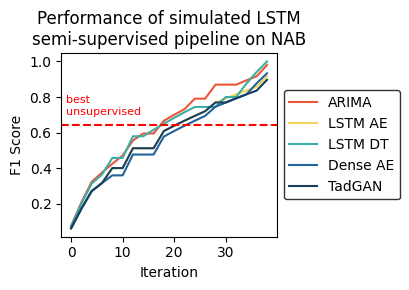

In [105]:
import matplotlib.pyplot as plt

labels = {
    "arima": 'ARIMA', 
    "lstm_autoencoder": 'LSTM AE', 
    "lstm_dynamic_threshold": 'LSTM DT', 
    "dense_autoencoder": 'Dense AE', 
    "tadgan": 'TadGAN'
}

fig = plt.figure(figsize=(4.2, 3))
for j, (k, score) in enumerate(all_scores.items()):
    plt.plot([i*2 for i in range(20)], score[:20], label=labels[k], color=colors[j])
    
plt.axhline(f1_results.loc['lstm_autoencoder']['NAB']['f1'], ls='--', c='r')
plt.text(-1, 0.7, "best\nunsupervised", c='r', fontsize=8)

plt.title('Performance of simulated LSTM\nsemi-supervised pipeline on NAB')
plt.ylabel('F1 Score')
plt.xlabel('Iteration')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), edgecolor='k')
plt.tight_layout()
plt.savefig('images/feedback.pdf');

In [96]:
from orion.evaluation import contextual_confusion_matrix

test = []
train = []

tot_anom = 0

DATA_PATH = 'sintel/data/{}'

for data, signals in dataset.items():
    for signal, result in signals.items():
        data_path = DATA_PATH.format(signal + '.csv')
        truth = load_anomalies(signal)
        train_ts, test_ts = load_signal(data_path, test_size=0.3)
        start = test_ts['timestamp'].min()
        test_truth = get_anomalies_in_test(truth, start)
        tot_anom += len(test_truth)
        for iteration in result:
            test_anom = iteration['test_anomalies']
            train_anom = iteration['train_anomalies']
            
            if isinstance(test_anom, tuple):
                for e in test_anom:
                    test.append(contextual_confusion_matrix(test_truth, e, weighted=False))

                for e in train_anom:
                    train.append(contextual_confusion_matrix(truth, e, weighted=False))
                    
            else:
                test.append(contextual_confusion_matrix(test_truth, test_anom, weighted=False))
                train.append(contextual_confusion_matrix(truth, train_anom, weighted=False))

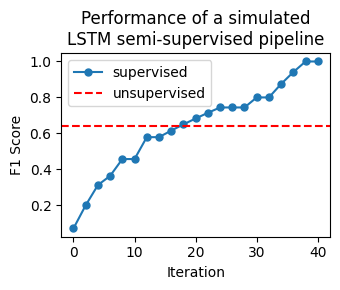

In [121]:
fig = plt.figure(figsize=(3.5, 3))
plt.plot([i*2 for i in range(21)], score, label='supervised', marker='o', markersize=5)
plt.axhline(0.640, ls='--', c='r', label='unsupervised')
plt.title('Performance of a simulated\nLSTM semi-supervised pipeline')
plt.ylabel('F1 Score')
plt.xlabel('Iteration')

# locs, labels = plt.xticks()
# labels = [x.get_text() for x in labels]
# labels[1:] = 
# labels[0] = -1
# labels[-1] += 1
# plt.xticks(locs, labels=labels)

plt.legend()
plt.tight_layout()
plt.savefig('images/feedback.pdf');

In [117]:
labels

['', 0, 8, 16, 24, 32, 40]